# Hidden Markov Model (HMM)

In [2]:
import numpy as np
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['figure.figsize'] = (15, 5)

### Markov Model

* Random stochastic transitions between a set of discrete states, with each transition ocurring at an average rate.
* *Memoryless*: Next transition depends only on the current state, not the past history.

### Hidden Markov Model

* We don't observe the states directly, but instead we observe a probabilistic output (emission) from each state.
* Observations are random variables from probability distributions that may differ for each state.

![HMM](images/hmm.png)

The probability of getting a particular sequence of observations $O_1, O_2, ...$ is given by

### $\begin{align}
P(O_1, O_2, ...) &= \sum_{S_1, S_2, ...} P(S_1) P(S_1 \rightarrow O_1) P(S_1 \rightarrow S_2)  P(S_2 \rightarrow O_2) P(S_2 \rightarrow S_3)  P(S_3 \rightarrow O_3) ... \\
                 &= \sum_{S_1, S_2, ...} P(S_1) P(S_1 \rightarrow O_1) \prod_{i \geq 2} P(S_{i-1} \rightarrow S_i)  P(S_i \rightarrow O_i)
\end{align}$

---
# 3-State HMM for Ion Channel Gating

A simple model of ion channel gating with two nonconducting states ($Closed, Desensitized$) and one conducting state ($Open$).

### $Closed \rightleftarrows Open \rightleftarrows Desensitized$

---
## Simulated State Sequence

In [3]:
# transition probability matrix for each time step
# A[i,j] is transition probability from state i to state j
A = np.array([[0.95, 0.05, 0.00],     # P(C->C), P(C->O), P(C->D)
              [0.03, 0.95, 0.02],     # P(O->C), P(O->O), P(O->D)
              [0.00, 0.004, 0.996]])  # P(D->C), P(D->O), P(D->D)

# initial state probabilities (i.e. probability that we start off in each state)
# p0[i] is the probability of starting in state i
p0 = np.array([1, 0, 0])     # P(C), P(O), P(D)

# memory for state sequence of time points
state_seq = np.zeros(1000000, dtype=int)

states = [0, 1, 2]

# set initial state by drawing from initial state probability array
state_seq[0] = np.random.choice(states, p=p0)

# for each subsequent time point, set the state based on the transition probabilities out of the current state
for t in range(len(state_seq)-1):
    state = state_seq[t]
    state_seq[t+1] = np.random.choice(states, p=A[state,:])

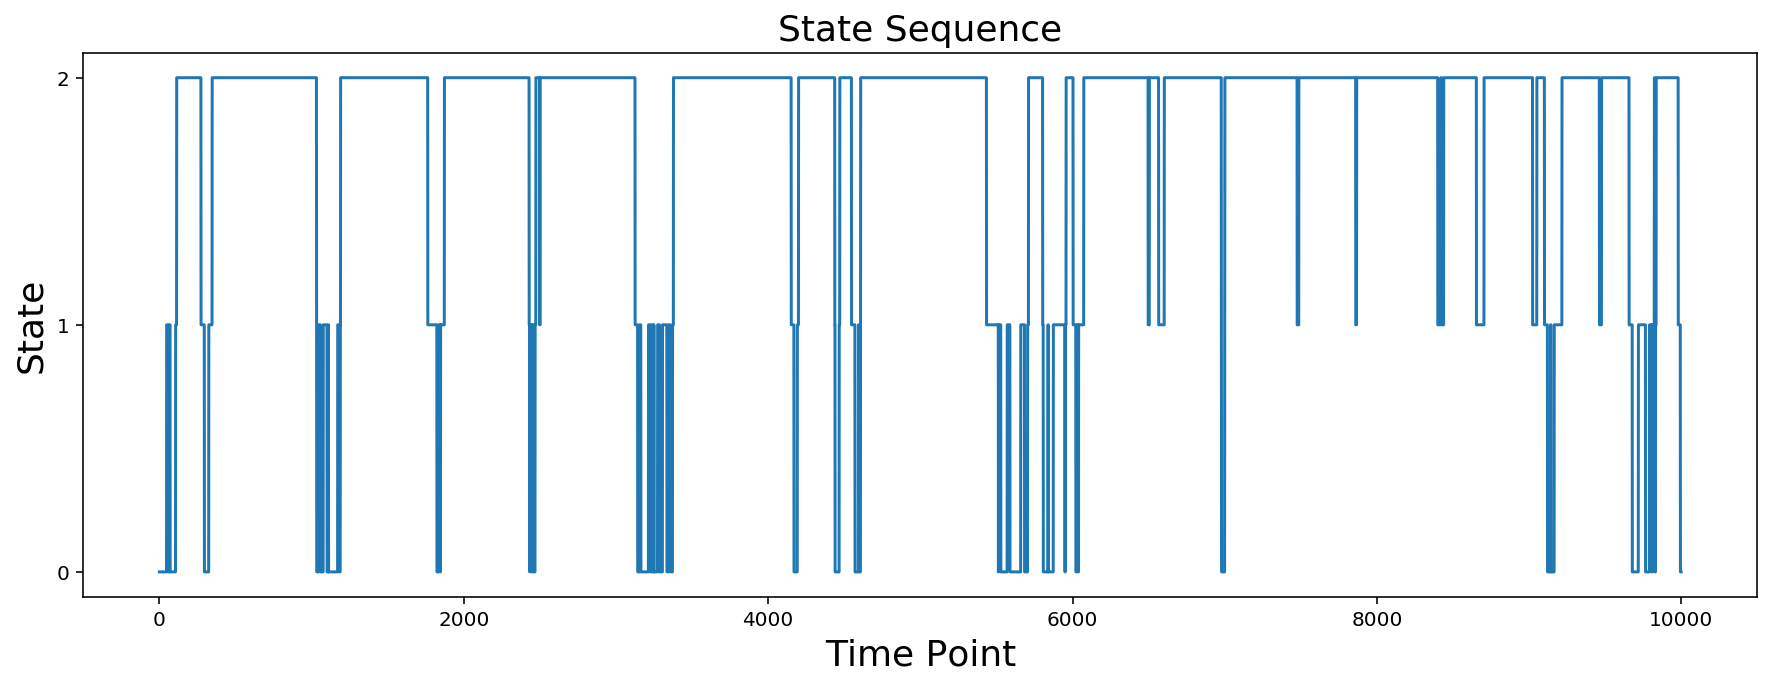

In [4]:
# plot the state sequence
N = 10000
plt.plot(state_seq[:N])
plt.yticks(states)
plt.xlabel('Time Point')
plt.ylabel('State')
plt.title('State Sequence');

---
## Simulated Hidden State Sequence ($C, O, D$) $\rightarrow$ Observed Channel Current

In [26]:
# emission probability distributions for each state
# state_emission_pds[i] is the emission probability distribution for state i
closed_pd = st.norm(0, 0.8)
open_pd = st.norm(5, 1)
desensitized_pd = st.norm(0, 0.8)

state_emission_pds = [closed_pd, open_pd, desensitized_pd]

# memory for observation sequence
current_pA = np.zeros(state_seq.shape)

# for each state in the sequence, generate an observed emission value
for state in states:
    indices = np.where(state_seq == state)[0]
    current_pA[indices] = state_emission_pds[state].rvs(len(indices))

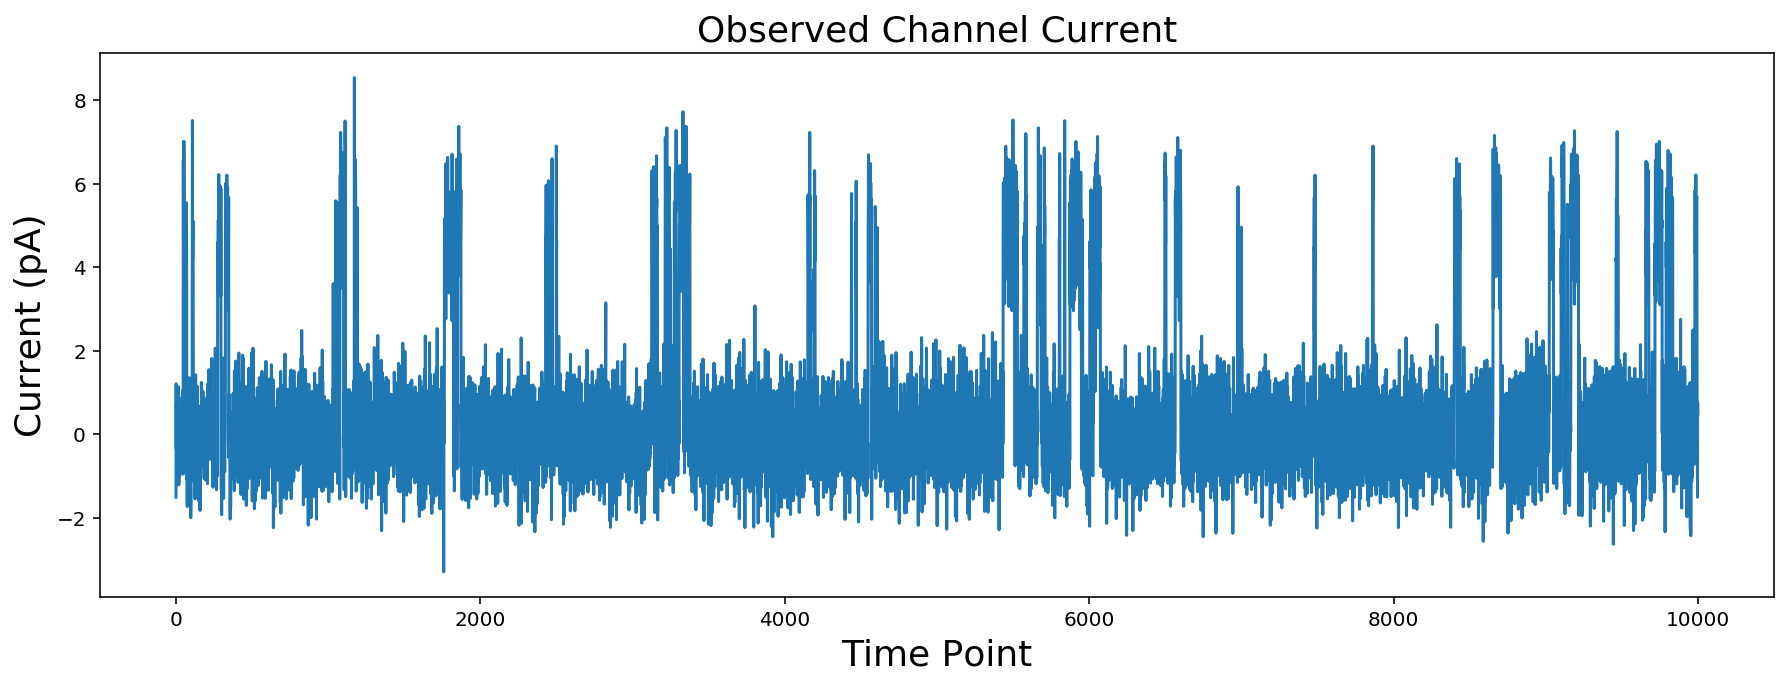

In [27]:
# plot the observed sequence
N = 10000
plt.plot(current_pA[:N])
plt.xlabel('Time Point')
plt.ylabel('Current (pA)')
plt.title('Observed Channel Current');

---
## Pomegranate

In [7]:
from pomegranate import *

# >>> conda update conda
# >>> conda install pomegranate

In [33]:
hmm = HiddenMarkovModel()

# states
C = State(NormalDistribution(0, 0.8), name='Closed')
O = State(NormalDistribution(5, 1), name='Open')
D = State(NormalDistribution(0, 0.8), name='Desensitized')

# add states to HMM
hmm.add_states([C, O, D])


# recall our initial state probabilities (i.e. probability that we start off in each state)
p0 = np.array([1, 0, 0])     # P(C), P(O), P(D)

# we can do the same thing here by adding transition probabilities from a 'start' state to the various states in our model
hmm.add_transition(hmm.start, C, 1)

# e.g. if we wanted to start in C or O with equal probability, ...
# hmm.add_transition(hmm.start, C, 0.5)
# hmm.add_transition(hmm.start, O, 0.5)


# recall our transition probability matrix for each time step
A = np.array([[0.95, 0.05, 0.00],     # P(C->C), P(C->O), P(C->D)
              [0.03, 0.95, 0.02],     # P(O->C), P(O->O), P(O->D)
              [0.00, 0.004, 0.996]])  # P(D->C), P(D->O), P(D->D)

# here, we explicitly add transitions with defined probabilities
hmm.add_transition(C, C, 0.95)  # P(C -> C) = 0.95
hmm.add_transition(C, O, 0.05)   # P(C -> O)  = 0.05

hmm.add_transition(O, C, 0.03)
hmm.add_transition(O, O, 0.95)
hmm.add_transition(O, D, 0.02)

hmm.add_transition(D, O, 0.004)
hmm.add_transition(D, D, 0.996)

# we have to bake the HMM before it is ready to use!
hmm.bake()

In [34]:
# !!! after we bake the HMM, the order of our states may be changed :(
# but we can easily get the new order from the HMM
states = [state.name for state in hmm.states]

# !!! None-start and None-end specify how state sequences start and end, but they are not actual states in the sequence
states

['Closed', 'Desensitized', 'Open', 'None-start', 'None-end']

In [35]:
hmm.dense_transition_matrix()

array([[0.95 , 0.   , 0.05 , 0.   , 0.   ],
       [0.   , 0.996, 0.004, 0.   , 0.   ],
       [0.03 , 0.02 , 0.95 , 0.   , 0.   ],
       [1.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   ]])

In [36]:
import pandas as pd

df = pd.DataFrame(hmm.dense_transition_matrix(), index=states, columns=states)

df

,Closed,Desensitized,Open,None-start,None-end
Closed,0.95,0.000,0.050,0.0,0.0
Desensitized,0.00,0.996,0.004,0.0,0.0
Open,0.03,0.020,0.950,0.0,0.0
None-start,1.00,0.000,0.000,0.0,0.0
None-end,0.00,0.000,0.000,0.0,0.0


In [38]:
sim_A = df[:3][states[:3]]

sim_A

,Closed,Desensitized,Open
Closed,0.95,0.000,0.050
Desensitized,0.00,0.996,0.004
Open,0.03,0.020,0.950


In [49]:
sim_p0 = pd.DataFrame(np.reshape(p0, (3,1)), index=states[:3], columns=["p0"])

sim_p0

,p0
Closed,1
Desensitized,0
Open,0


In [50]:
sim_emissions = pd.DataFrame([state.distribution.parameters for state in hmm.states[:3]], index=states[:3], columns=['mean', 'std'])

sim_emissions

,mean,std
Closed,0.0,0.8
Desensitized,0.0,0.8
Open,5.0,1.0


---
## Probability of the current observations given the HMM.

In [28]:
hmm.probability(current_pA)  # underflow (value below smallest possible digital representation)

0.0

In [29]:
hmm.probability(current_pA[:100])  # less points

1.3162102323439712e-60

In [51]:
sim_logp = hmm.log_probability(current_pA)  # addition instead of multiplication of probabilities mitigates underflow problem

sim_logp

-1300574.903544317

---
## Training/Optimizing an HMM on observed data.

1. Start with the observed channel current (i.e. your data measurements).
2. Examine the data. e.g. look at the current amplitudes.
3. Idealize the data based on the number of postulated current levels.
4. From the idealized data examine lifetime distributions in each current level.
5. From the current levels and their lifetime distributions postulate an HMM that could explain your data. Use whatever other information you have to help construct the HMM, but keep it as simple as possible.
6. Set the HMM parameters (i.e. starting and transition probabilities and emission probability distributions) to an initial guess based on your observations of the data.
7. Optimize the HMM parameters to best explain your data. !!! THIS DOES NOT MEAN THAT THE MODEL YOU GET IS THE BEST POSSIBLE MODEL TO EXPLAIN YOUR DATA. IT JUST MEANS THAT THESE ARE THE BEST PARAMETERS FOR THIS MODEL TO EXPLAIN YOUR DATA.
8. Try other HMMs differeing in numbers of states or connectivity by allowed transitions and compare to see which one is most likely to explain your data.

---
## Let's make a new model and start with initial parameters that are not exactly those used to simulate the observed current data.

In [52]:
hmm = HiddenMarkovModel()

C = State(NormalDistribution(0, 0.5), name='Closed')
O = State(NormalDistribution(4, 1.2), name='Open')
D = State(NormalDistribution(0, 1), name='Desensitized')

hmm.add_states([C, O, D])

hmm.add_transition(hmm.start, C, 0.5)
hmm.add_transition(hmm.start, O, 0.3)
hmm.add_transition(hmm.start, D, 0.2)

hmm.add_transition(C, C, 0.90)
hmm.add_transition(C, O, 0.1)

hmm.add_transition(O, C, 0.01)
hmm.add_transition(O, O, 0.98)
hmm.add_transition(O, D, 0.01)

hmm.add_transition(D, O, 0.10)
hmm.add_transition(D, D, 0.90)

hmm.bake()

states = [state.name for state in hmm.states]

In [53]:
start_A = pd.DataFrame(hmm.dense_transition_matrix()[:3,:3], index=states[:3], columns=states[:3])

start_A

,Closed,Desensitized,Open
Closed,0.90,0.00,0.10
Desensitized,0.00,0.90,0.10
Open,0.01,0.01,0.98


In [54]:
start_p0 = pd.DataFrame(np.reshape(hmm.dense_transition_matrix()[3,:3], (3,1)), index=states[:3], columns=["p0"])

start_p0

,p0
Closed,0.5
Desensitized,0.2
Open,0.3


In [55]:
start_emissions = pd.DataFrame([state.distribution.parameters for state in hmm.states[:3]], index=states[:3], columns=['mean', 'std'])

start_emissions

,mean,std
Closed,0.0,0.5
Desensitized,0.0,1.0
Open,4.0,1.2


In [56]:
start_logp = hmm.log_probability(current_pA)  # addition instead of multiplication of probabilities mitigates underflow problem

start_logp

-1462075.8678729136

---
## Optimize the new HMM parameters for the first 1,000 time points of the observed current.

### Baum-Welch expectation maximization (EM) algorithm aims to find the model parameters that maximize the probability of a given observation sequence.

In [58]:
hmm.fit([current_pA[:1000]], algorithm='baum-welch');

In [59]:
fit1k_A = pd.DataFrame(hmm.dense_transition_matrix()[:3,:3], index=states[:3], columns=states[:3])

fit1k_A

,Closed,Desensitized,Open
Closed,0.982277,0.000000,1.772284e-02
Desensitized,0.000000,1.000000,1.003654e-13
Open,0.061671,0.015417,9.229122e-01


In [60]:
fit1k_p0 = pd.DataFrame(np.reshape(hmm.dense_transition_matrix()[3,:3], (3,1)), index=states[:3], columns=["p0"])

fit1k_p0

,p0
Closed,1.000000e+00
Desensitized,3.699230e-114
Open,0.000000e+00


In [61]:
fit1k_emissions = pd.DataFrame([state.distribution.parameters for state in hmm.states[:3]], index=states[:3], columns=['mean', 'std'])

fit1k_emissions

,mean,std
Closed,0.029113,0.755938
Desensitized,0.009474,0.821355
Open,4.966031,0.878476


In [62]:
fit1k_logp = hmm.log_probability(current_pA)  # addition instead of multiplication of probabilities mitigates underflow problem

fit1k_logp

-1314448.4689041441

## Optimize the new HMM parameters for the first 10,000 time points of the observed current.

In [63]:
hmm.fit([current_pA[:10000]], algorithm='baum-welch');

In [64]:
fit10k_A = pd.DataFrame(hmm.dense_transition_matrix()[:3,:3], index=states[:3], columns=states[:3])

fit10k_A

,Closed,Desensitized,Open
Closed,0.954250,0.000000,0.045750
Desensitized,0.000000,0.997017,0.002983
Open,0.040651,0.022610,0.936739


In [65]:
fit10k_p0 = pd.DataFrame(np.reshape(hmm.dense_transition_matrix()[3,:3], (3,1)), index=states[:3], columns=["p0"])

fit10k_p0

,p0
Closed,1.000000e+00
Desensitized,3.333247e-145
Open,0.000000e+00


In [66]:
fit10k_emissions = pd.DataFrame([state.distribution.parameters for state in hmm.states[:3]], index=states[:3], columns=['mean', 'std'])

fit10k_emissions

,mean,std
Closed,0.017766,0.780996
Desensitized,-0.005327,0.814213
Open,5.000387,1.002632


In [67]:
fit10k_logp = hmm.log_probability(current_pA)  # addition instead of multiplication of probabilities mitigates underflow problem

fit10k_logp

-1301156.4236958427

## Optimize the new HMM parameters for the first 100,000 time points of the observed current.

In [68]:
hmm.fit([current_pA[:100000]], algorithm='baum-welch');

In [69]:
fit100k_A = pd.DataFrame(hmm.dense_transition_matrix()[:3,:3], index=states[:3], columns=states[:3])

fit100k_A

,Closed,Desensitized,Open
Closed,0.952965,0.000000,0.047035
Desensitized,0.000000,0.996033,0.003967
Open,0.027934,0.021980,0.950086


In [70]:
fit100k_p0 = pd.DataFrame(np.reshape(hmm.dense_transition_matrix()[3,:3], (3,1)), index=states[:3], columns=["p0"])

fit100k_p0

,p0
Closed,1.000000e+00
Desensitized,6.319899e-153
Open,0.000000e+00


In [71]:
fit100k_emissions = pd.DataFrame([state.distribution.parameters for state in hmm.states[:3]], index=states[:3], columns=['mean', 'std'])

fit100k_emissions

,mean,std
Closed,0.000539,0.797755
Desensitized,-0.001152,0.806253
Open,5.004874,1.007671


In [72]:
fit100k_logp = hmm.log_probability(current_pA)  # addition instead of multiplication of probabilities mitigates underflow problem

fit100k_logp

-1300621.1370816932

---
## Training/Optimization seeks to maximize the probability that the model would give rise to the observed data.

In [91]:
sim_logp, start_logp, fit1k_logp, fit10k_logp, fit100k_logp

(-1300574.903544317,
 -1462075.8678729136,
 -1314448.4689041441,
 -1301156.4236958427,
 -1300621.1370816932)

---
## Use the optimized HMM to predict the state sequence underlying the observed current.

In [73]:
N = 1000

predicted_state_seq = hmm.predict(current_pA[:N])

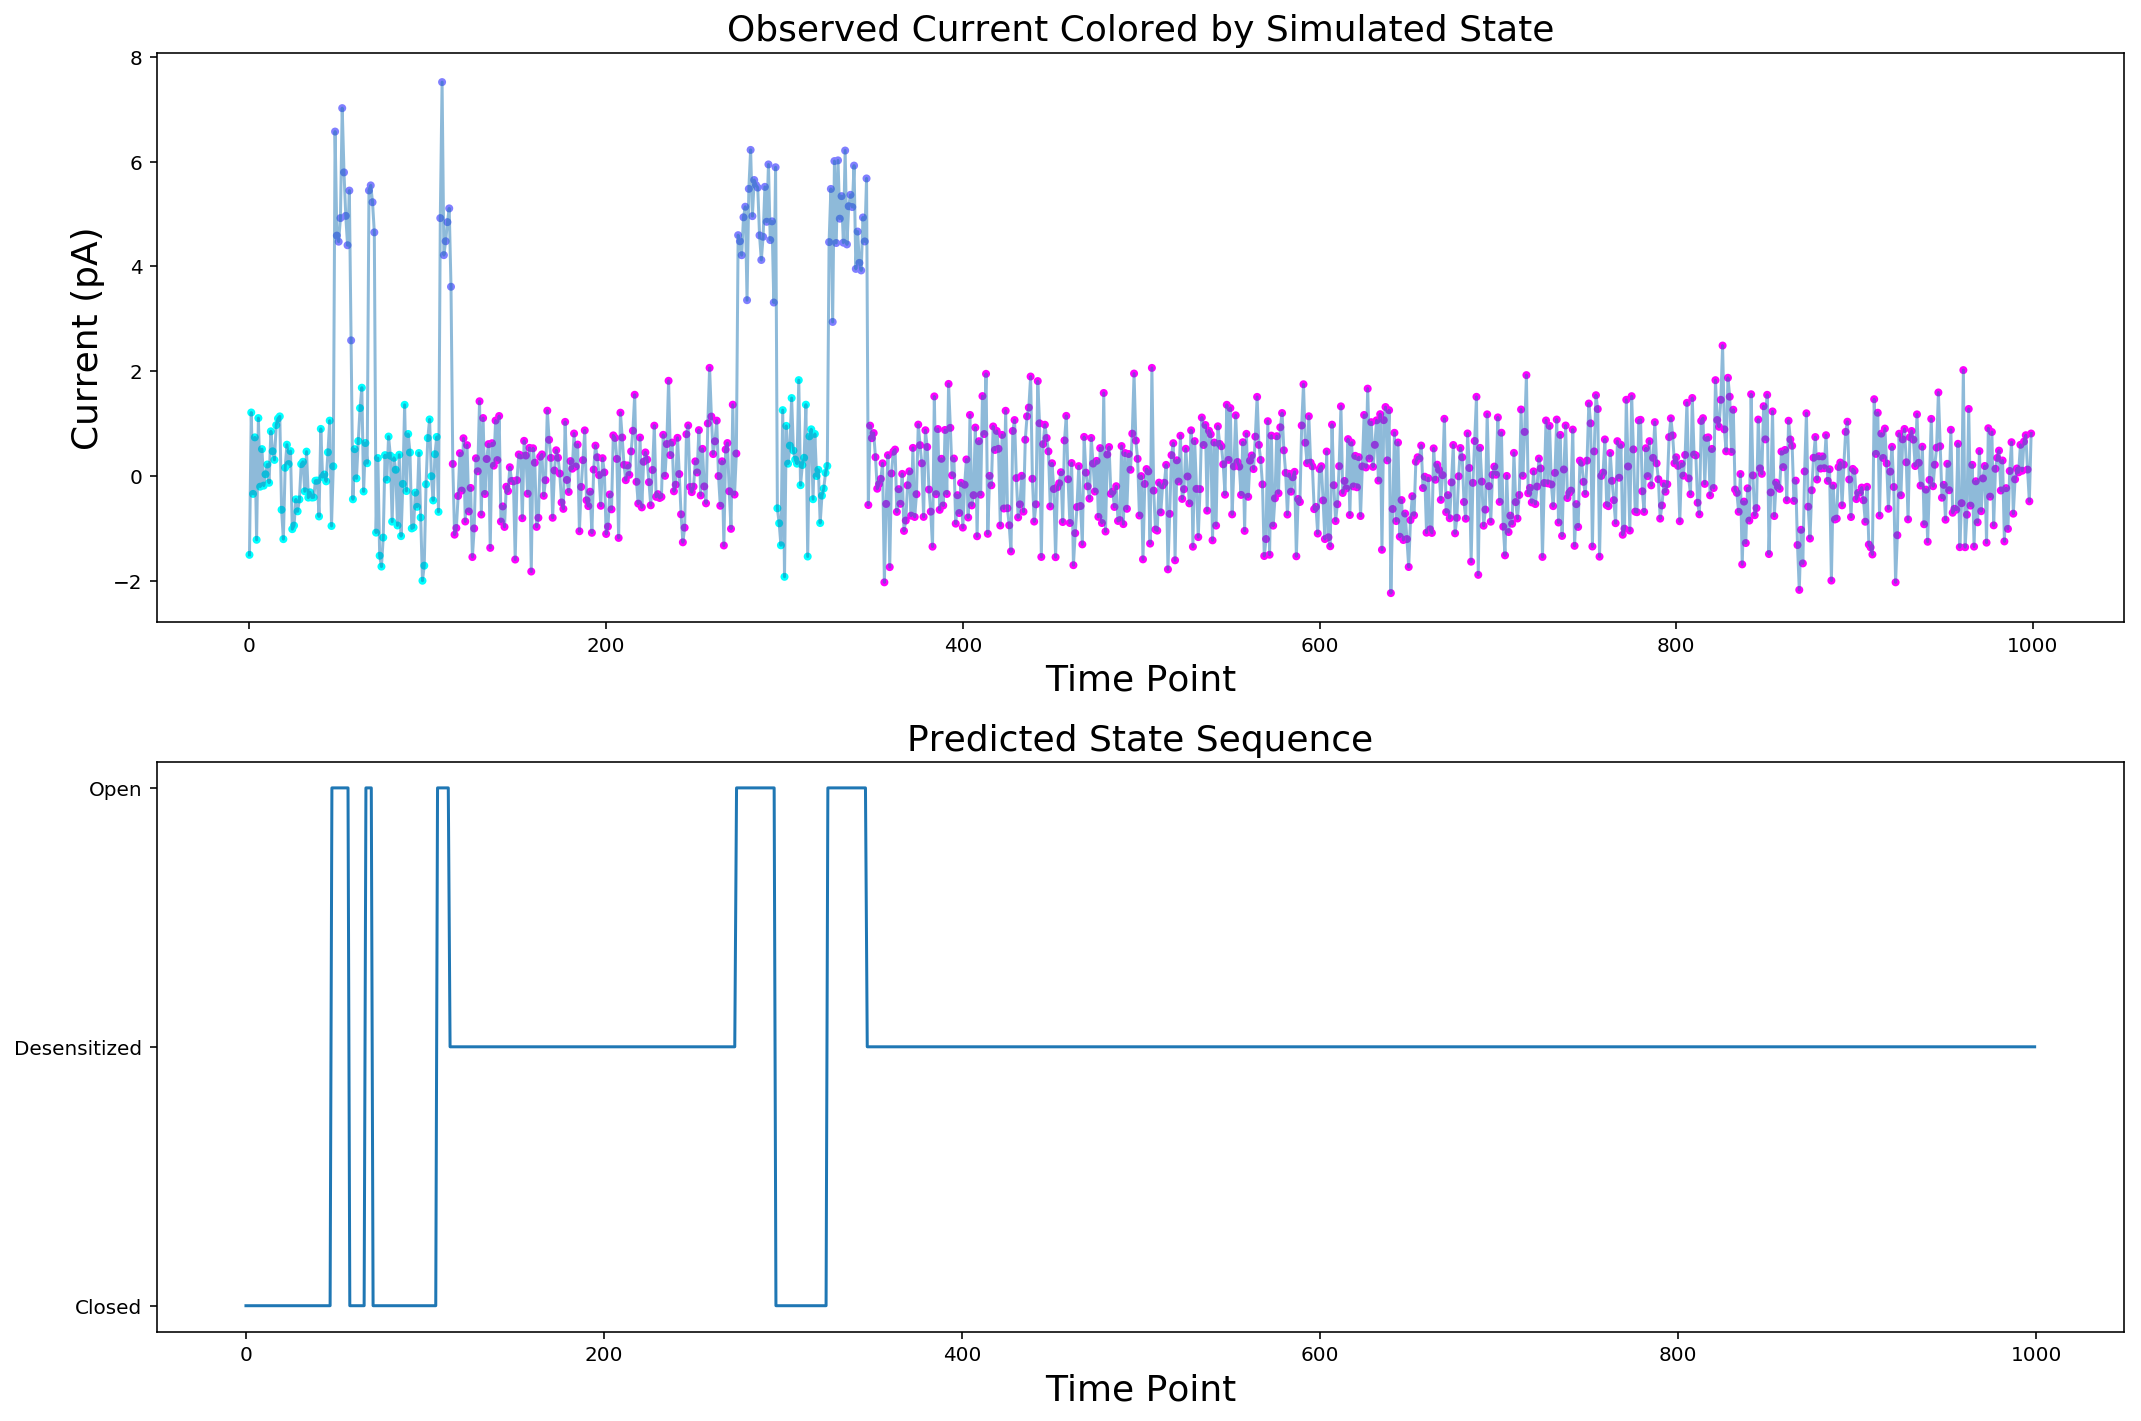

In [81]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
plt.plot(current_pA[:N], alpha=0.5)
plt.scatter(range(N), current_pA[:N], marker='.', c=state_seq[:N], cmap='cool')
plt.xlabel('Time Point')
plt.ylabel('Current (pA)')
plt.title('Observed Current Colored by Simulated State')

plt.subplot(212)
plt.plot(predicted_state_seq[:N])
plt.yticks([0, 1, 2], states[:3])
plt.xlabel('Time Point')
plt.title('Predicted State Sequence')

plt.tight_layout();

---
## Use the trained HMM to predict the probability to be in each state at every time point.

In [82]:
N = 1000

predicted_state_prob = hmm.predict_proba(current_pA[:N])
predicted_state_logprob = hmm.predict_log_proba(current_pA[:N])

predicted_state_prob.shape, predicted_state_logprob.shape

((1000, 3), (1000, 3))

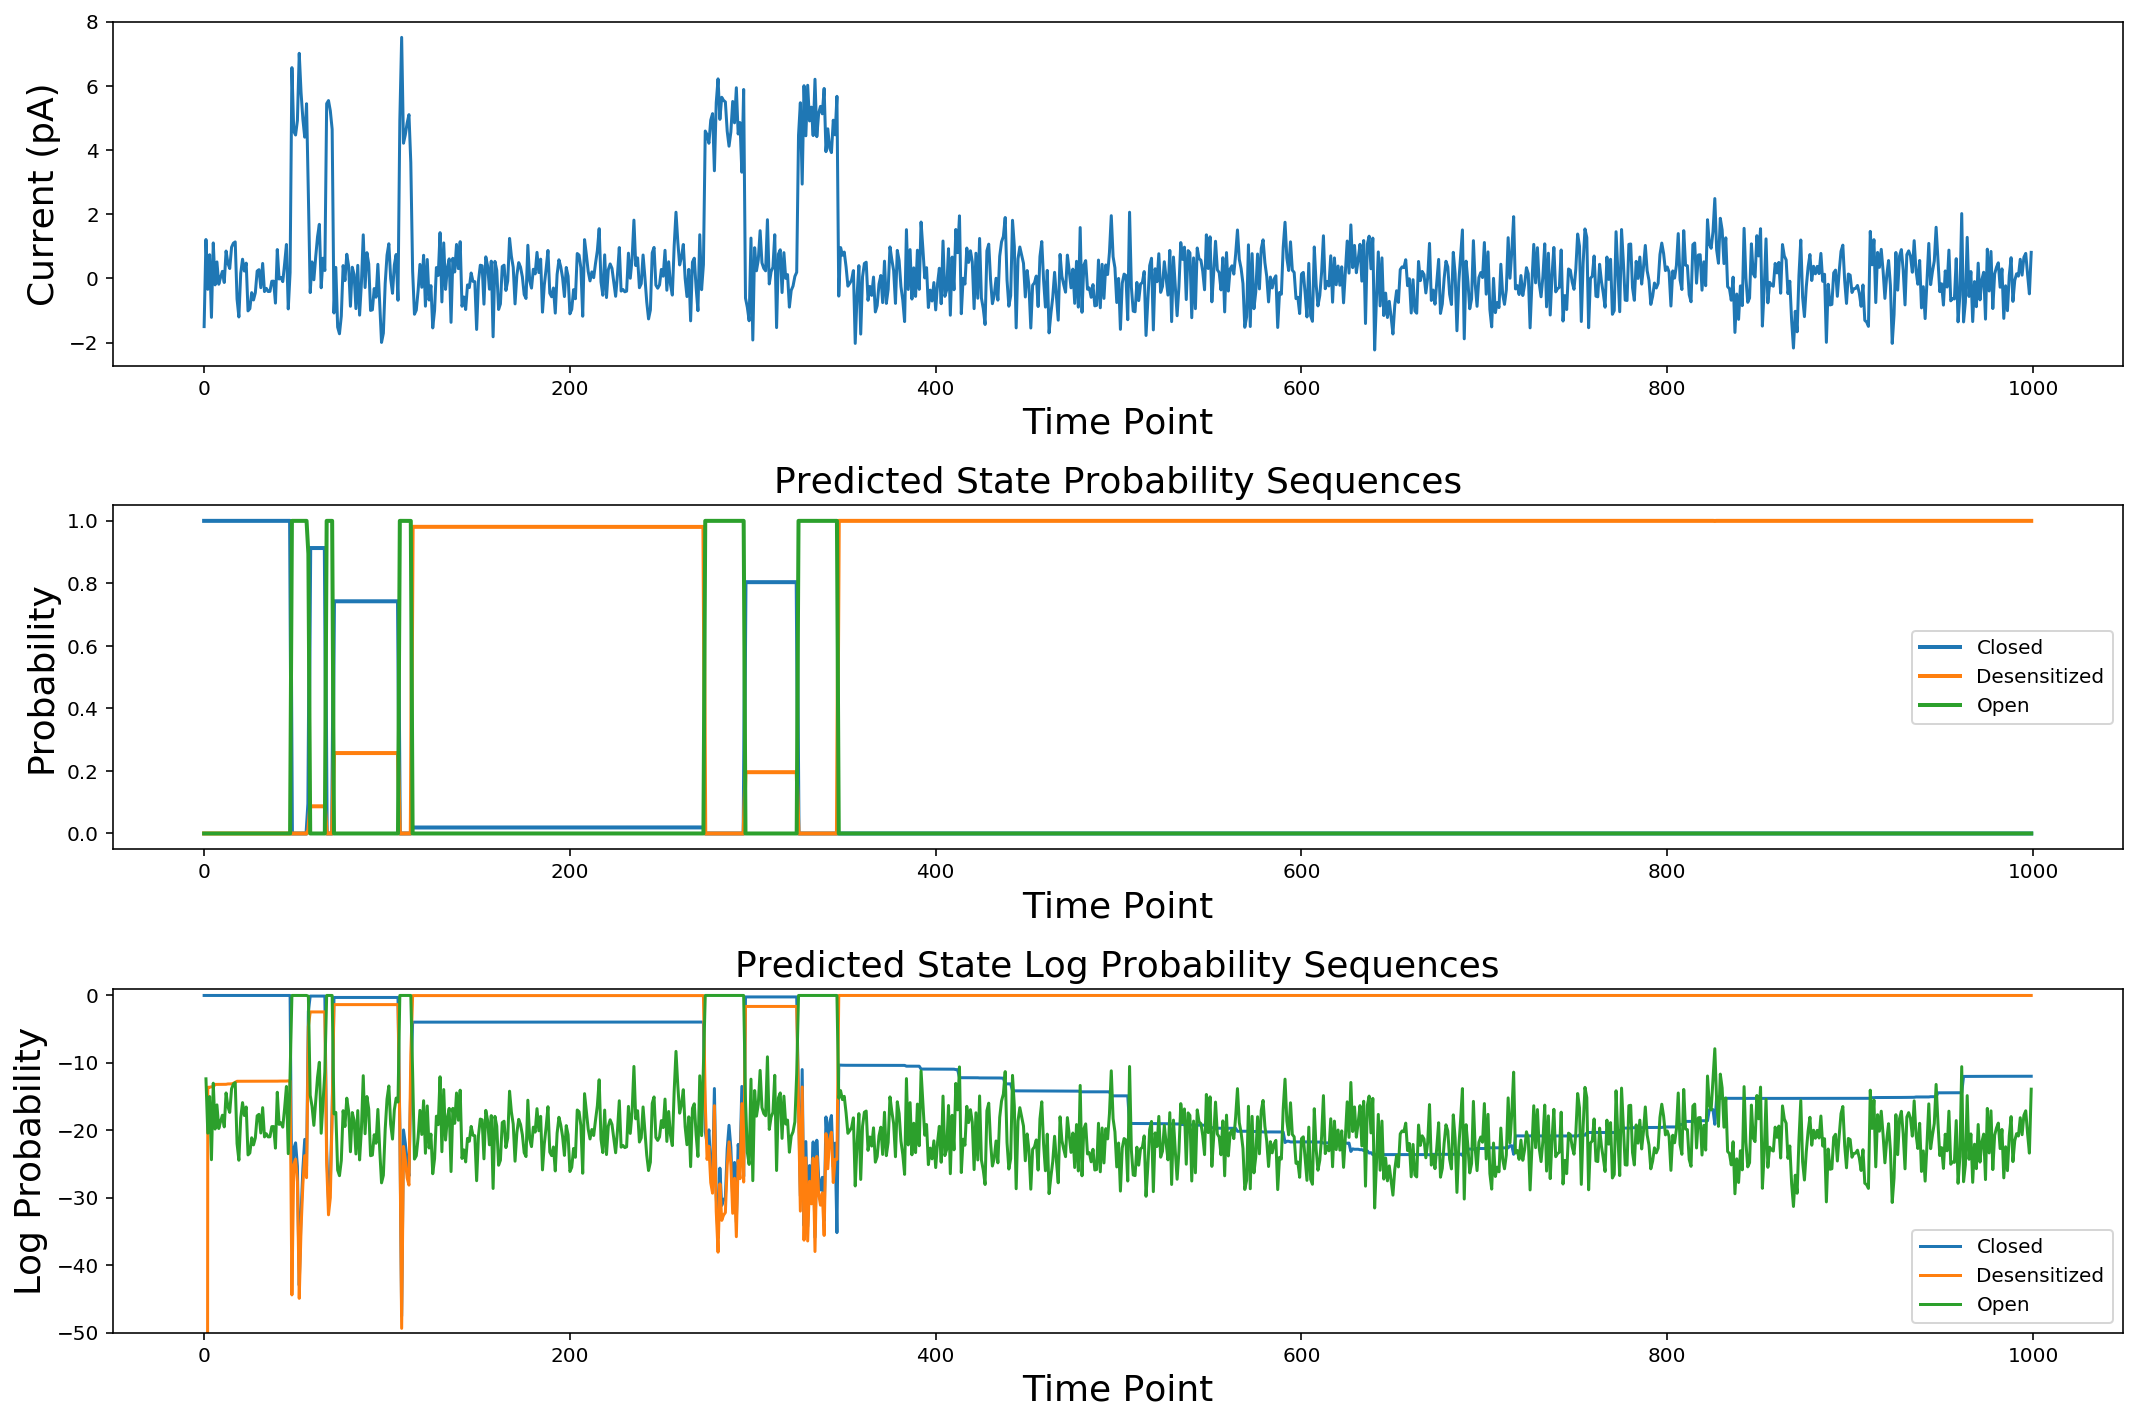

In [90]:
plt.figure(figsize=(15, 10))

plt.subplot(311)
plt.plot(current_pA[:N])
plt.xlabel('Time Point')
plt.ylabel('Current (pA)')

plt.subplot(312)
plt.plot(predicted_state_prob, lw=2)
plt.xlabel('Time Point')
plt.ylabel('Probability')
plt.title('Predicted State Probability Sequences')
plt.legend(states[:3])

plt.subplot(313)
plt.plot(predicted_state_logprob)
plt.ylim([-50, 1])
plt.xlabel('Time Point')
plt.ylabel('Log Probability')
plt.title('Predicted State Log Probability Sequences')
plt.legend(states[:3])

plt.tight_layout();

---
## How to choose between multiple possbile models?

In [100]:
hmm2 = HiddenMarkovModel()

C = State(NormalDistribution(0, 1), name='Closed')
O = State(NormalDistribution(4, 1), name='Open')
D = State(NormalDistribution(0, 1), name='Desensitized')

hmm2.add_states([C, O, D])

hmm2.add_transition(hmm2.start, C, 1)

hmm2.add_transition(C, C, 0.90)
hmm2.add_transition(C, O, 0.05)
hmm2.add_transition(C, D, 0.05)  # <-- NEW ALLOWED TRANSITION FROM C -> D

hmm2.add_transition(O, C, 0.05)
hmm2.add_transition(O, O, 0.90)
hmm2.add_transition(O, D, 0.05)

hmm2.add_transition(D, C, 0.05)  # <-- NEW ALLOWED TRANSITION FROM D -> C
hmm2.add_transition(D, O, 0.05)
hmm2.add_transition(D, D, 0.90)

hmm2.bake()

states2 = [state.name for state in hmm2.states]

In [101]:
hmm2.fit([current_pA[:100000]], algorithm='baum-welch');

In [103]:
fit100k_A2 = pd.DataFrame(hmm2.dense_transition_matrix()[:3,:3], index=states2[:3], columns=states2[:3])

fit100k_A2

,Closed,Desensitized,Open
Closed,0.993328,0.006670,0.000002
Desensitized,0.016363,0.955453,0.028184
Open,0.000022,0.049893,0.950085


In [104]:
fit100k_emissions2 = pd.DataFrame([state.distribution.parameters for state in hmm2.states[:3]], index=states2[:3], columns=['mean', 'std'])

fit100k_emissions2

,mean,std
Closed,-0.003334,0.807894
Desensitized,0.004783,0.799319
Open,5.004879,1.007660


In [106]:
fit100k_logp2 = hmm2.log_probability(current_pA)

fit100k_logp, fit100k_logp2

(-1300621.1370816932, -1300624.3384470919)

## Based on log probability this new model seems like it might be a contender.

## However, it has more parameters than the previous model (two additional transitions).

## *The more parameters a model has, the more likely it will be able to fit the data well even if it is not the right model.*

## Bayesian (BIC) or Akaike (AIC) Information Criterion are two metrics that weight the model's goodness of fit against its number of parameters.

## We can use these or similar metrics to compare multiple models. The best choice have the smallest values of BIC or AIC.

#### $AIC = -2 * loglikelihood + 2 * (# of model parameters)$

#### $BIC = -2 * loglikelihood + log(# of data points) * (# of model parameters)$

In [111]:
# Each state has 2 emission parameters (mean and std)
# So total model parameters is 3 * 2 + # of allowed transitions

aic1 = -2 * hmm.log_probability(current_pA) + 2 * (3 * 2 + 4)
aic2 = -2 * hmm2.log_probability(current_pA) + 2 * (3 * 2 + 6)

bic1 = -2 * hmm.log_probability(current_pA) + np.log(len(current_pA)) * (3 * 2 + 4)
bic2 = -2 * hmm2.log_probability(current_pA) + np.log(len(current_pA)) * (3 * 2 + 6)

print('AIC1:', aic1)
print('AIC2:', aic2)
print()
print('BIC1:', bic1)
print('BIC2:', bic2)

AIC1: 2601262.2741633863
AIC2: 2601272.6768941837

BIC1: 2601380.429268966
BIC2: 2601414.4630208793
